<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you have implement some popular adversarial attacks on the well-known pretrained image classification networks.

After that you should try some defences against those attacks.

Fortunately, you shouldn't try to fine-tune adversarial attacks to overcome the above adversarial defences.

In [156]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from tqdm import trange

In [2]:
# get ImageNet class labels
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
use_DataParallel = False

class TransformInputWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return self.net(x)

def prepare_net(net):
    net = net.train(False)
    if torch.cuda.is_available():
        net = net.cuda()
    for x in net.parameters():
        x.requires_grad_(False)
    if use_DataParallel:
        net = nn.DataParallel(net)
    net = TransformInputWrapper(net)
    return net

In [4]:
from torchvision.models import inception_v3, vgg, resnet

In [5]:
# let's use inception_v3 as it is fast and lightweight
# you can try another architecture if you want though
net = inception_v3(True)
net = prepare_net(net)
device = next(net.parameters()).device

In [6]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None, mind_aspect_ratio=True):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget "{url}" -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    if mind_aspect_ratio:
        d = min(img.shape[:2])
        img = img[img.shape[0] // 2 - d // 2: img.shape[0] // 2 - d // 2 + d,
                  img.shape[1] // 2 - d // 2: img.shape[1] // 2 - d // 2 + d]
    img = resize(img, (299, 299), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img.clip(0, 1))
    plt.axis('off')

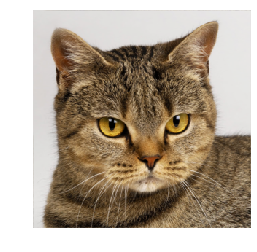

In [7]:
img = obtain_image(url="https://c.wallhere.com/photos/46/bf/cat_muzzle_eyes-1020991.jpg!d")
show_img(img)

In [8]:
def np_to_torch(img):
    return torch.from_numpy(img).permute([2, 0, 1]).to(device=device, dtype=next(net.parameters()).dtype)

In [9]:
def torch_to_np(torch_img):
    return torch_img.permute([1, 2, 0]).clone().detach_().cpu().numpy()

In [10]:
def print_classification(probs, top_categories=5):
    top_ix = (-probs.numpy()).argsort()
    print('Idx   Prob    Caption')
    for ix in top_ix[:top_categories]:
        print('%04d  %.04f  %s' % (ix, probs[ix], labels[ix]))

In [110]:
def draw_attack(init, attack=None):
    attack_scale_factor = 5
    n = 1
    fontsize = 16
    net_input = np_to_torch(init)[None]
    if attack is not None:
        n += 2
        net_input = torch.cat([net_input, np_to_torch(attack)[None]])
    with torch.no_grad():
        probs = torch.softmax(net(net_input), 1).cpu()
    plt.figure(figsize=(n * 5, 5))
    plt.subplot(1, n, 1)
    show_img(init)
    plt.title('Initial', fontsize=fontsize)
    print('Initial classification:')
    print_classification(probs[0])
    if attack is not None:
        plt.subplot(1, n, 2)
        show_img(0.5 + attack_scale_factor * (attack - init))
        plt.title('Attack', fontsize=fontsize)
        plt.subplot(1, n, 3)
        show_img(attack)
        plt.title('Image with attack', fontsize=fontsize)
        print()
        print('Classification after attack:')
        print_classification(probs[1])

In [124]:
def draw_defenses(init, names=[], defenses=[]):
    attack_scale_factor = 5
    n = len(defenses)
    fontsize = 16
    net_input = torch.cat([np_to_torch(x)[None] for x in defenses])
    with torch.no_grad():
        probs = torch.softmax(net(net_input), -1).cpu()
    plt.figure(figsize=(n * 5, 10))
    for i, (name, defense, result) in enumerate(zip(names, defenses, probs)):
        plt.subplot(2, n, i + 1)
        show_img(0.5 + attack_scale_factor * (defense - init))
        plt.title(name + ' (diff)', fontsize=fontsize)
        plt.subplot(2, n, i + n + 1)
        show_img(defense)
        plt.title(name + ' (image)', fontsize=fontsize)
        print(name + ':')
        print_classification(probs[i])
        print()

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0671  0.7994  mountain bike, all-terrain bike, off-roader
0444  0.0145  bicycle-built-for-two, tandem bicycle, tandem
0535  0.0079  disk brake, disc brake
0518  0.0078  crash helmet
0970  0.0034  alp


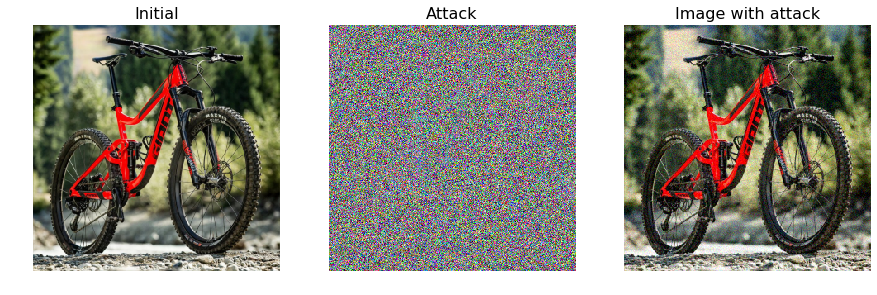

In [123]:
draw_attack(img, (img + np.random.randn(*img.shape) * 0.05).clip(0, 1))

Defense #1:
Idx   Prob    Caption
0671  0.8613  mountain bike, all-terrain bike, off-roader
0535  0.0085  disk brake, disc brake
0444  0.0081  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0053  crash helmet
0970  0.0026  alp

Defense #2:
Idx   Prob    Caption
0671  0.8671  mountain bike, all-terrain bike, off-roader
0444  0.0076  bicycle-built-for-two, tandem bicycle, tandem
0535  0.0074  disk brake, disc brake
0518  0.0055  crash helmet
0970  0.0027  alp



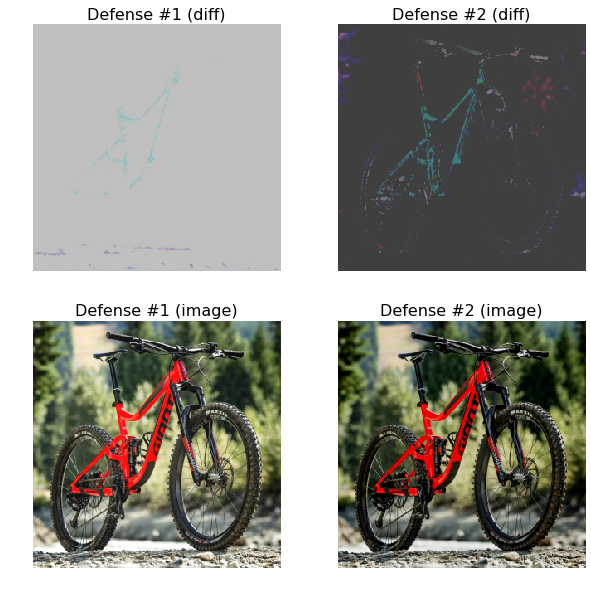

In [125]:
draw_defenses(img, ['Defense #1', 'Defense #2'], [(img + 0.05).clip(0, 1), (img - 0.05).clip(0, 1)])

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp


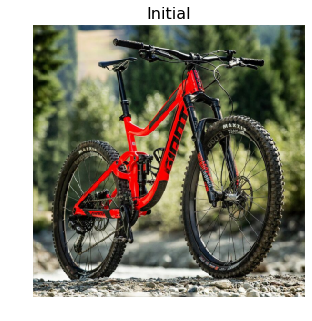

In [112]:
img = obtain_image(url="https://avatars.mds.yandex.net/get-pdb/2000092/f8a7d9f0-8537-475b-8f78-57ae9dcd8360/s1200?webp=false")
draw_attack(img)

### Code requirements
Each attack below must be implemented as a separate function which takes torch tensor of shape (3, 299, 299) and returns the tensor of the same shape - an adversarial sample.
Debug output is allowed in small quanities.

## Adversarial attacks

Here we consider the _evasion_ adversarial attacks, i. e. attacks on the classifier at the testing phase.

In general, there are two kinds of evasion adversarial attack.

+ _Non-targeted_ attack causes the classifier to predict any inccorect label for the adversarial image which is similar to the original. The specific incorrect label does not matter.
+ _Targeted_ attack aims to change the classifier’s prediction to some specific target class.


Mathematically, those two attack can be formulated as follows:
+ Non-targeted attack
$$x_{adv} = \operatorname*{argmin}\limits_{\begin{gather} s. t. \\ f(x) \neq f(x_{original}) \\ x \in [0,1]^D \end{gather}} dist(x_{original}, x)$$
+ Targeted attack
$$x_{adv} = \operatorname*{argmin}\limits_{\begin{gather} s. t. \\ f(x) = target \\ x \in [0,1]^D \end{gather}} dist(x_{original}, x)$$

The distance metric is usually $||x - x_{original}||_p$. Here $r := x - x_{original}$ is called adversarial _perturbation_.

Surely, the above problems are very hard to be solved conventionally, because of very complex form of the optimization contraints.

That is why the above problems are usually reformulated using some penalty function $J_f$:
$$x_{adv} = \operatorname*{argmin}\limits_{s. t. ~ x \in [0,1]^D}dist(x_{original}, x) + c J_f(x)$$

Usually $J_f$ depends on the model probabilities of the classes for the given input $F_i(x) = p_f(y = i | x)$ or on the logits $Z_i(x) = \log p_f(y = i | x)$ of such probabilities.

### White-box attacks

This type of attack is applicable if you know the architecture and the weight of the model.
Therefore, you can compute the outputs of network given any input and the gradient w. r. t. this input.

#### L-BFGS

<a href="https://arxiv.org/pdf/1312.6199.pdf">Link to the paper.</a>

It is the first popular method to generate adversarial samples.
It is designed as a targeted attack method, though it can be easily reformulated for non-targeted attack.

The method uses L-BFGS optimization method with box contraints to solve the above optimization problem.
The authors also propose to perform linear search for such minimal $c$ so that $f(x_{adv}) = target$.

You will minimize $-Z_{target}(x_{adv})$ as penalty function $J_f$ and use $dist(x_{orignial}, x_{adv}) = ||x_{original} - x_{adv}||_2^2$.

In [14]:
from scipy.optimize import minimize

In [132]:
class LossFunction:
    def __init__(self, img, c, target):
        self.img = img
        self.c = c
        self.target = target
        # your code here
    
    def torch_loss(self, x):
        # your code here

    @torch.no_grad()
    def loss(self, x):
        x_torch = np_to_torch(x.reshape(*self.img.shape))
        return float(self.torch_loss(x_torch))

    def grad(self, x):
        x_torch = np_to_torch(x.reshape(*self.img.shape))
        x_torch = x_torch.requires_grad_(True)
        loss = self.torch_loss(x_torch)
        loss.backward()
        return torch_to_np(x_torch.grad).ravel().astype(self.img.dtype)

In [159]:
# check your loss function is correct
ll = LossFunction(img, 1000, 281)
ll.loss(img.copy().ravel()), ll.grad(img.copy().ravel())

(9318.34375, array([-0.10888766,  0.02009212,  0.03366374, ...,  0.04846111,
        -0.01577175, -0.05033058]))

In [134]:
def lbfgs_attack_try_c(img, c, target):
    ll = LossFunction(img, c, target)
    # your code here
    return  # a tuple: whether the attack with given c was successfull,
            # what is l_2-norm of perturbation, and the adversarial sample

In [135]:
def lbfgs_attack(img, target, c_l=0, c_r=10, c_tol=0.5):
    img = torch_to_np(img)
    res = lbfgs_attack_try_c(img, c_r, target)
    assert res[0]
    x_adv = res[2]
    print('C: %.06f; Success: %s; L2-dist: %.06f' % (c_r, str(res[0]), res[1]))
    # your code with linear search of minimal suitable c is here
    # hint: binary search is adviced
    return np_to_torch(x_adv)

C: 10.000000; Success: True; L2-dist: 2.736424
C: 5.000000; Success: True; L2-dist: 2.605500
C: 2.500000; Success: True; L2-dist: 2.432005
C: 1.250000; Success: False; L2-dist: 0.996092
C: 1.875000; Success: False; L2-dist: 1.321823
C: 2.187500; Success: False; L2-dist: 1.691827
Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0281  0.5756  tabby, tabby cat
0282  0.1095  tiger cat
0671  0.0542  mountain bike, all-terrain bike, off-roader
0283  0.0480  Persian cat
0539  0.0185  doormat, welcome mat


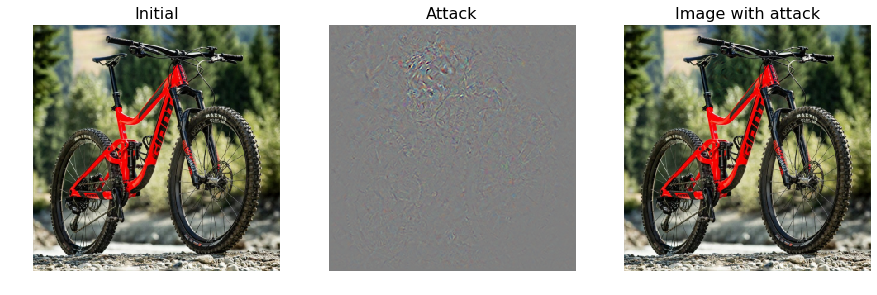

In [22]:
x_adv = torch_to_np(lbfgs_attack(np_to_torch(img), 281))
draw_attack(img, x_adv)

#### Fast gradient sign method (FGSM)

<a href="https://arxiv.org/pdf/1412.6572.pdf">Link to the paper.</a>

This attack was designed as a non-targeted one.

$J_f$ is supposed to be the cost used to train the neural network, i. e. $J_f(x) = -Z_{orig\_class}(x)$.

The idea is to make only one step towards the gradient of the penalty loss. I. e. perturbation is

$$ r = \varepsilon \operatorname*{sign} \nabla_x J_f(x)$$

Note that method requires only one gradient evaluation to perform attack, so it is extremelly fast relatively to other methods. On the other hand, success rate of such an attack is relatively low.

As you can see, $\varepsilon$ is $l_\infty$ measure of the perturbation.

Try $\varepsilon = \frac{1}{255} \approx 0.007$ and $\varepsilon = 0.1$.

In [26]:
def fgsm_attack(x, eps):
    # your code is here
    return x_adv

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0671  0.1633  mountain bike, all-terrain bike, off-roader
0444  0.0686  bicycle-built-for-two, tandem bicycle, tandem
0870  0.0382  tricycle, trike, velocipede
0999  0.0163  toilet tissue, toilet paper, bathroom tissue
0880  0.0158  unicycle, monocycle


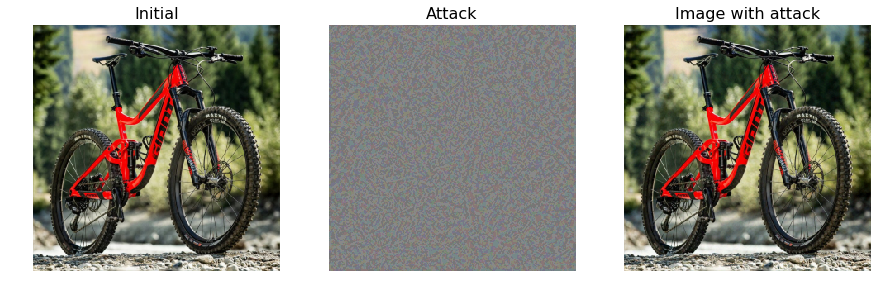

In [15]:
x_adv = torch_to_np(fgsm_attack(np_to_torch(img), 0.007))
draw_attack(img, x_adv)

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0591  0.3575  handkerchief, hankie, hanky, hankey
0669  0.0566  mosquito net
0443  0.0267  bib
0636  0.0203  mailbag, postbag
0434  0.0193  bath towel


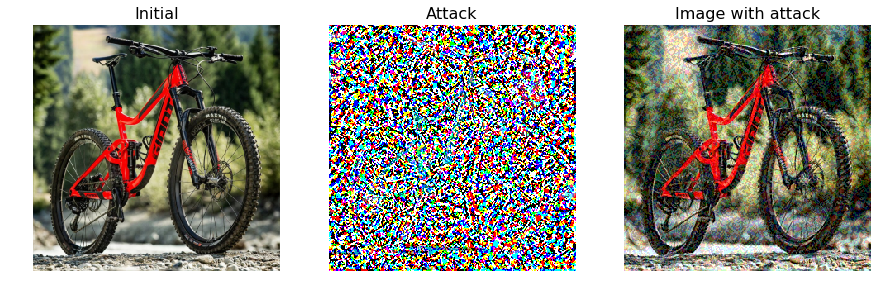

In [16]:
x_adv = torch_to_np(fgsm_attack(np_to_torch(img), 0.1))
draw_attack(img, x_adv)

#### DeepFool

<a href="https://arxiv.org/pdf/1511.04599.pdf">Link to the paper.</a>

This method is designed to be a non-targeted attack.

The idea is to linearize the neural network output for each class w. r. t. the input.
After that method analytically finds the nearest point which changes the prediction of the linear substitute classifier.
The process repeats from the new point if it doesn't change classifier class.

$$f(x) \approx \operatorname*{argmin}\limits_{k} (w_k^\mathrm{T} x_0 + b_k)$$
$$w_k = \nabla_x Z_k(x_N)$$

For each $k \neq orig\_class$:
+ $Z_k(x) \approx w_k^\mathrm{T} x + b_k$
+ $Z_{orig\_class}(x) \approx w_{orig\_class}^\mathrm{T} x + b_{orig\_class}$
+ $w'_k = w_k - w_{orig\_class}$; $f'_k = Z_k(x) - Z_{orig\_class}$.
+ Under the linear assumption, the point where the classifier prediction changes, i. e. $w_k^\mathrm{T} x + b_k = w_{orig\_class}^\mathrm{T} x + b_{orig\_class}$, is $$x_N + \frac{|f'_k|}{||w'_k||_2^2}w'_k$$

+ In order to get to the other class space instead of the classes boundary, overshot coefficient $0.02$ plus $1$ is multiplied on the coefficient before $w'_k$.

At each step we choose such $k$ so that distance between current and proposal point (which appears to be $1.02 \cdot \frac{|f'_k|}{||w'_k||_2}$) is minimal and do the step:
$$x_{N + 1} = \operatorname{Clip}_{[0, 1]}\left(x_N + 1.02 \cdot \frac{|f'_k|}{||w'_k||_2^2}w'_k\right)$$

If the attack successfull, return $x_{N + 1}$, otherwise make one more step.

Because of a large number of classes in ImageNet, authors also propose to find a boundary with only top-10 next-to-original classes w. r. t. value of $Z_i(x_N)$.

In [136]:
def deepfool_attack(img, num_classes_to_check=10, overshoot=0.02, max_iters=100):
    # your code is here
    return x

Early stopping: iteration 3
Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0444  0.2863  bicycle-built-for-two, tandem bicycle, tandem
0671  0.2862  mountain bike, all-terrain bike, off-roader
0870  0.0524  tricycle, trike, velocipede
0880  0.0075  unicycle, monocycle
0535  0.0072  disk brake, disc brake


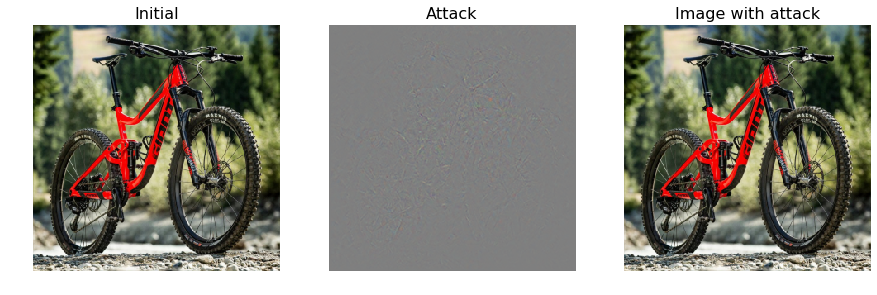

In [72]:
x_adv = torch_to_np(deepfool_attack(np_to_torch(img)))
draw_attack(img, x_adv)

#### Basic Iterative Method (BIM), also sometimes called Iterative FGSM (I-FGSM)

<a href="https://arxiv.org/pdf/1607.02533.pdf">Link to the paper.</a>

FGSM can often reach an acceptable solution in one very large step.
The method repeatedly applies FGSM for several steps with a smaller stepsize $\alpha$.
Such a procedure generates an example in $l_\infty$ ball with radius $N \cdot \alpha$.
Yet it has much higher success rate than the original FGSM.

The paper covers both targeted and non-targeted attack scenarios.

$J_f$ for targeted attack is $Z_{target}(x)$.

$$x_{N + 1}^{adv} = \operatorname*{Clip_{[0,1]}}(x_{N}^{adv} + \alpha \operatorname*{sign} \nabla_x J_f(x_{N}^{adv}))$$

Maximal number of iterations $max\_iters = \operatorname*{round}(\min(\frac{\varepsilon}{\alpha} + 4, 1.25 \cdot \frac{\varepsilon}{\alpha}))$, where $\varepsilon$ is the estimated $l_\infty$-boundary for the perturbation.

$\alpha = \frac{1}{255}$

In [137]:
def i_fgsm_attack(img, target=None, alpha=1/255, eps=0.04):
    max_iters = round(min(eps / alpha + 4, 1.25 * eps / alpha))
    # your code is here
    # note: here you must handle both targeted and non-targeted attack case,
    #       the later case is defined by target=None.
    return x_adv

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0444  0.0468  bicycle-built-for-two, tandem bicycle, tandem
0870  0.0399  tricycle, trike, velocipede
0999  0.0312  toilet tissue, toilet paper, bathroom tissue
0671  0.0291  mountain bike, all-terrain bike, off-roader
0700  0.0276  paper towel


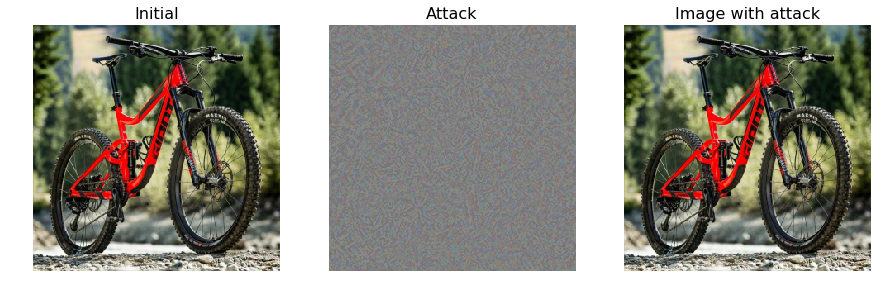

In [34]:
x_adv = torch_to_np(i_fgsm_attack(np_to_torch(img)))
draw_attack(img, x_adv)

Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0281  0.1153  tabby, tabby cat
0671  0.1053  mountain bike, all-terrain bike, off-roader
0518  0.0743  crash helmet
0478  0.0223  carton
0539  0.0180  doormat, welcome mat


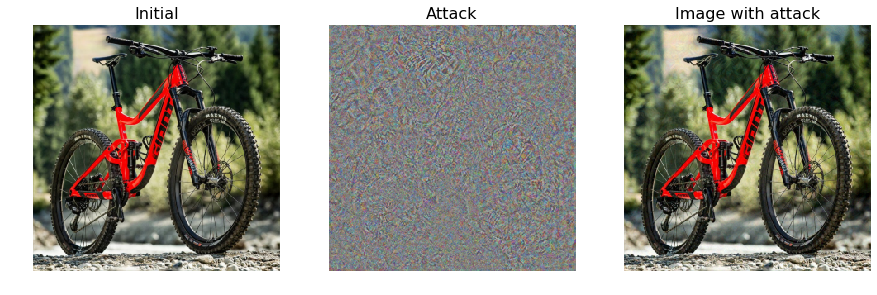

In [35]:
x_adv = torch_to_np(i_fgsm_attack(np_to_torch(img), 281))
draw_attack(img, x_adv)

#### Carlini and Wagner attack (C&W)

<a href="https://arxiv.org/pdf/1608.04644.pdf">Link to the paper.</a>

The attack is designed as a targeted one.
The loss function is, as usual

$$\min\limits_{x \in [0,1]^D}||x_{original} - x||_2^2 + cJ_f(x)$$

For targeted attack $J_f(x) = \max(\max\limits_{i \neq target} Z_i(x) - Z_{target}(x), -\kappa)$.

For non-targeted case similar loss is $J_f(x) = \max(Z_{orig_class}(x) - \max\limits_{i \neq orig\_class} Z_i(x), -\kappa)$

Thus, $c > 0$ and $\kappa \geqslant 0$ are method parameters. Greater $\kappa$ forces more classification confidence on the adversarial sample.

The optimization method in this paper is Adam.
Authors propose two ways to enforce box contraints: projecting results onto box constraints after each Adam step or by change of variables, i. e. $x = 0.5(\tanh(w) + 1)$, $w \in \mathbb{R}^D$.
The later is more popular, thus you have to implement it in this section.

The paper contains method modification for $l_0$ and $l_\infty$ perturbation deistance metric, you may see it as well if you are interested.

In [144]:
def carlini_wagner_attack(img, target, c=10, kappa=0, max_iters=1000, learning_rate=1e-3):
    # your code is here
    return x_adv

6.666289 + 10.000000 * -0.473329 = 1.932999: 100%|██████████| 1000/1000 [00:20<00:00, 49.66it/s] 


Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0281  0.0363  tabby, tabby cat
0671  0.0213  mountain bike, all-terrain bike, off-roader
0539  0.0212  doormat, welcome mat
0283  0.0199  Persian cat
0282  0.0179  tiger cat


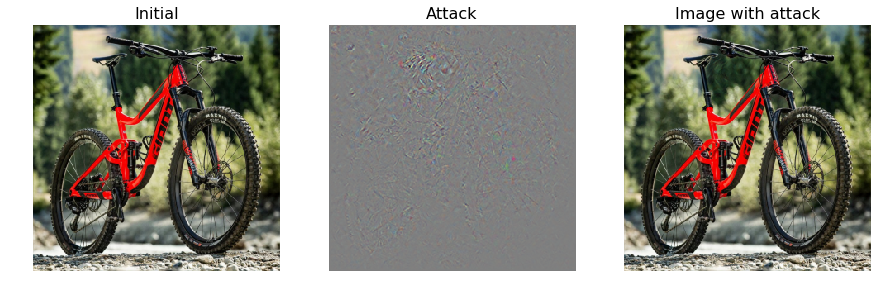

In [76]:
x_adv = torch_to_np(carlini_wagner_attack(np_to_torch(img), 281, kappa=0.5))
draw_attack(img, x_adv)

35.693336 + 10.000000 * -12.000000 = -84.306664: 100%|██████████| 1000/1000 [00:27<00:00, 36.78it/s]


Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0281  0.9999  tabby, tabby cat
0283  0.0000  Persian cat
0282  0.0000  tiger cat
0285  0.0000  Egyptian cat
0539  0.0000  doormat, welcome mat


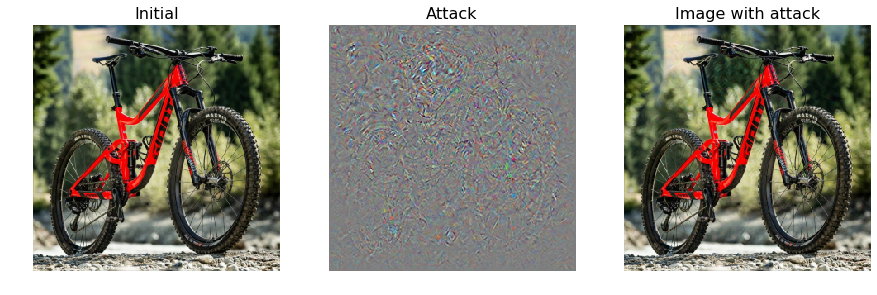

In [148]:
x_adv = torch_to_np(carlini_wagner_attack(np_to_torch(img), 281, kappa=12))
draw_attack(img, x_adv)

### Black box attacks

In this section the only communication with the attacked network is allowed through the functions below.

In [ ]:
@torch.no_grad()
def Z_unnormalized(x):
    return net(x.clamp(0, 1))

In [ ]:
@torch.no_grad()
def Z(x):
    return torch.log_softmax(net(x.clamp(0, 1)), -1)

#### One-pixel attack

<b>This attack is optional because it requires additional investigation to make it work properly. You don't have to implement it if you don't want to.</b>

<a href="https://arxiv.org/pdf/1710.08864.pdf">Link to the paper.</a>

The attack is non-targeted.

The main idea is that we fix a number of pixels $N$ to change.
Each solution is described by the set of integers $[(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)]$ and real values $[(r_1, g_1, b_1), (r_2, g_2, b_2), \dots, (r_N, g_N, b_N)]$.

After that we apply some genetic algorithm over the population of such solutions.

For simplicity we use large $N=300$ here.

<b>Note:</b> To make the attack work in current setting you'll have to design the mutation, crossingover and fitness functions by yourself.
According to my experiments, just implementing the algorithm from the paper is not enough.


In [110]:
def N_pixel_attack(img, N, batch_size=32, population_size=400, max_iters=100):
    # your code here
    return x_adv

Best: -0.039:  68%|██████▊   | 137/200 [22:48<10:15,  9.76s/it]


Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0444  0.3119  bicycle-built-for-two, tandem bicycle, tandem
0671  0.3000  mountain bike, all-terrain bike, off-roader
0870  0.0569  tricycle, trike, velocipede
0535  0.0072  disk brake, disc brake
0880  0.0067  unicycle, monocycle


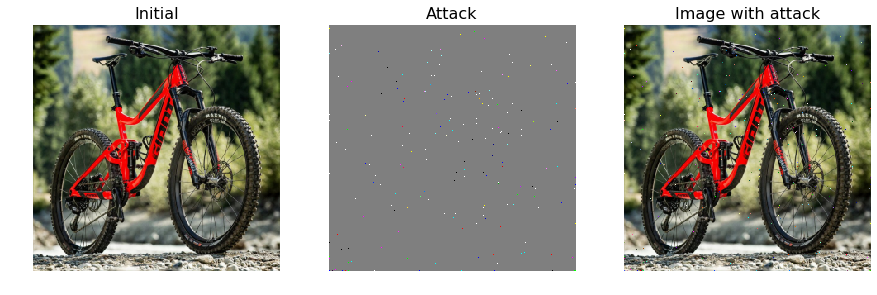

In [138]:
x_adv = torch_to_np(N_pixel_attack(np_to_torch(img), N=300, population_size=400, max_iters=200))
draw_attack(img, x_adv)

#### Zeroth Order Optimization (ZOO)

<a href="https://arxiv.org/pdf/1708.03999.pdf">Link to the paper.</a>

This paper proposes both targeted and non-targeted attack.
Both of those attacks use loss function from C&W method.

Here we implement only non-targeted version because it is easier.

The constraint loss for non-targeted case is as follows:
$$J_f(x) = \max(Z_{orig_class}(x) - \max\limits_{i \neq orig\_class} Z_i(x), -\kappa)$$

The loss is $||x_{original} - x_{adv}||_2^2 + c \cdot J_f(x)$.

The first trick to optimize such function is attack-space dimension reduction.
Instead of working in 299x299x3-dimensional space we perform optimization in, for example, 32x32x3-dimensional space.
We use transformation $D: 32 \times 32  \times 3 \to 299  \times 299  \times 3$ to map the low-dimensional space into the space of the original perturbations. Bilinear transformation is a good choice for $D$.
Therefore, the loss becomes
$$\min\limits_{y} ||D(y)||_2^2 + c \cdot J_f(\operatorname{Clip}_{[0, 1]}(x_{original} + D(y)))$$

Btw, for targeted version of the method authors use a hierarchical sequence of such transformations, i. e. firstly they optimize low-dimensional perturbation $y_1 \in \mathbb{R}^{32 \ times 32 \times 3}$, and then they upscale it and begin to optimize $y_2 \in \mathbb{R}^{64 \ times 64 \times 3}$.

For the i-th component of derivative w. r. t. $y$ we use approximation $g_i \approx \frac{loss(y + h \cdot e_i) - loss(y - h \cdot e_i)}{2h}$ where $h = 10^{-4}$.

The optimization method is coordinate-wise Adam with $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\varepsilon = 10^{-8}$, $\eta = 0.01$.
Coordinate-wise means that on one step we take a random batch of dimensions and estimate the gradient w.r.t. them.
After that we do the Adam step over these dimensions and repeat procedure.

In [154]:
def zoo(img, learning_rate=0.01, kappa=0.5, c=10, batch_size=32, max_iters=6000):
    # your code here
    return x_adv

Loss: 71.570312, term1: 76.570312, term2: -0.500000:  10%|▉         | 596/6000 [04:49<43:37,  2.06it/s]


Early stopping: 597 iteration of 6000
Initial classification:
Idx   Prob    Caption
0671  0.8648  mountain bike, all-terrain bike, off-roader
0535  0.0082  disk brake, disc brake
0444  0.0079  bicycle-built-for-two, tandem bicycle, tandem
0518  0.0051  crash helmet
0970  0.0025  alp

Classification after attack:
Idx   Prob    Caption
0535  0.3290  disk brake, disc brake
0671  0.2008  mountain bike, all-terrain bike, off-roader
0444  0.0147  bicycle-built-for-two, tandem bicycle, tandem
0815  0.0093  spider web, spider's web
0665  0.0078  moped


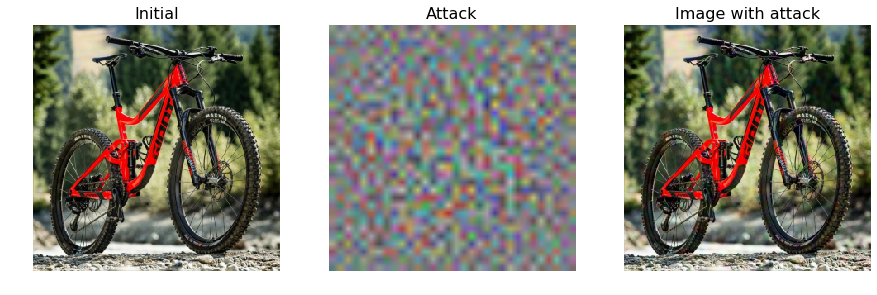

In [140]:
x_adv = torch_to_np(zoo(np_to_torch(img), kappa=0.5))
draw_attack(img, x_adv)

## Defenses

The main lines of research in defense from adversarial attacks:
+ The most popular and probably effective is _adversarial training_.
The method means fune-tuning or even training from scratch on adversarial examples or on the mixture of adversarial examples and clean data.
Unfortunately, the method tends to overfit for a certain type of attack that was used in training.
Another key drawback of adversarial training is that it tends to inadvertently learn to do gradient masking rather than to actually move the decision boundary.
+ Adversarial perturbations detection.
This approach works long as the attacker is unaware of the detector or the attack is not strong enough. Otherwise theattacker can construct an attack which simultaneously fools the detector into thinking an adversarial input is a legitimate input and fools the classifier into making thewrong classification.
+ Gradient masking.
Gradient masking means making the gradient useless, either by changing the model in some way that makes it non-differentiable or makes it have zero gradients in most places, or make the gradients point away from the decision boundary.
Essentially, gradient masking means breaking the optimizer without actually moving the class decision boundaries substantially.
Because the class decision boundaries are more or less the same, defenses based on gradient masking are highly vulnerable to black box transfer.
+ Denoising methods.
Because a lot of attacks seems to be high-frequency noise (not true for all attacks, when blurred with a low pass filter, adversarial perturbations are often found to have significant low-frequency components) multiple authors have suggested to use image preprocessing as a potential defence against adversarial examples.
There is a large variation in the proposed preprocessing techniques, like doing JPEG compression or applying median filtering and reducing precision of input data.



Here we try only denoising methods because they are extremelly easy to be applied.

In [99]:
from PIL import Image
from io import BytesIO
from scipy.ndimage import median_filter, gaussian_filter

def denoise_JPEG(img, quality=70, subsampling='4:1:1'):
    # your code here

def denoise_median(img, filter_size=3):
    # your code here

def denoise_gaussian(img, sigma=1):
    # your code here

def denoise_reduce_colorspace(img):
    # your code here

In [ ]:
def test_defenses(img, x_adv):
    draw_attack(img, x_adv)
    x_def_reduced_cs = denoise_reduce_colorspace(x_adv)
    x_def_median = denoise_median(x_adv, 3)
    x_def_gauss = denoise_gaussian(x_adv, 1)
    x_def_JPEG = denoise_JPEG(x_adv, 70, '4:1:1')
    print()
    draw_defenses(img,
                  ['Reduce colorspace', 'Median filter', "Gaussian filter", "JPEG compression"],
                  [x_def_reduced_cs, x_def_median, x_def_gauss, x_def_JPEG])

In [ ]:
x_adv = torch_to_np(lbfgs_attack(np_to_torch(img), 281))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(fgsm_attack(np_to_torch(img), 0.007))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(fgsm_attack(np_to_torch(img), 0.1))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(deepfool_attack(np_to_torch(img)))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(i_fgsm_attack(np_to_torch(img)))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(i_fgsm_attack(np_to_torch(img), 281))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(carlini_wagner_attack(np_to_torch(img), 281, kappa=0.5))
test_defenses(img, x_adv)

In [ ]:
x_adv = torch_to_np(carlini_wagner_attack(np_to_torch(img), 281, kappa=30, learning_rate=1e-2))
test_defenses(img, x_adv)

# Conclusions

A place for your conclusions, observations, hypotheses.